In [1]:
import json
import os
import glob
import matplotlib.pyplot as plt

In [2]:
for i in range(10):
    print(i)
    os.system("./build/src/tuk_numa_benchmark --benchmark_format=json > sequential_{}.json".format(i))

0
1
2
3
4
5
6
7
8
9


In [3]:
def add_benchmarks(merged_dict, f_dict):
    for benchmark in f_dict['benchmarks']:
        merged_dict[benchmark['name']].append(benchmark['real_time'])
    return merged_dict

In [4]:
json_files = glob.glob('*.json')
merged_dict = dict()
for json_file in json_files:
    f = open(json_file, "r").read()
    f_dict = json.loads(f.replace('\x00', ''))
    if not bool(merged_dict):
    # Dict is empty
        for benchmark in f_dict['benchmarks']:
            merged_dict[benchmark['name']] = []
    merged_dict = add_benchmarks(merged_dict, f_dict) 
merged_dict

{'BM_ColumnScan_1GB_Sequential_Local_1_Columns': [62,
  53,
  48,
  58,
  44,
  44,
  51,
  54,
  62,
  57],
 'BM_ColumnScan_1GB_Sequential_Local_2_Columns': [127,
  100,
  96,
  91,
  106,
  90,
  98,
  89,
  100,
  89],
 'BM_ColumnScan_1GB_Sequential_Local_4_Columns': [242,
  181,
  196,
  182,
  268,
  208,
  217,
  218,
  199,
  176],
 'BM_ColumnScan_1GB_Sequential_Local_8_Columns': [476,
  529,
  385,
  383,
  530,
  353,
  398,
  358,
  397,
  355],
 'BM_ColumnScan_1GB_Sequential_Remote_1_Columns': [68,
  63,
  49,
  50,
  63,
  44,
  48,
  58,
  60,
  56],
 'BM_ColumnScan_1GB_Sequential_Remote_2_Columns': [117,
  125,
  97,
  96,
  136,
  91,
  96,
  90,
  102,
  90],
 'BM_ColumnScan_1GB_Sequential_Remote_4_Columns': [239,
  252,
  194,
  201,
  178,
  176,
  194,
  208,
  204,
  179],
 'BM_ColumnScan_1GB_Sequential_Remote_8_Columns': [488,
  502,
  401,
  491,
  403,
  454,
  397,
  383,
  415,
  478]}

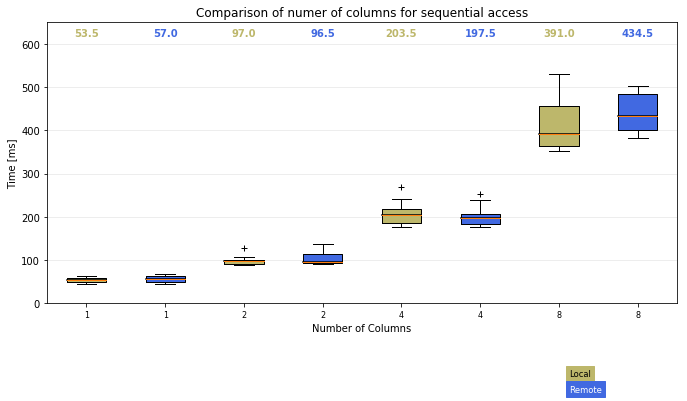

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
N = 500
numDists = 4
sortedKeys = ['BM_ColumnScan_1GB_Sequential_Local_1_Columns', 'BM_ColumnScan_1GB_Sequential_Remote_1_Columns', 'BM_ColumnScan_1GB_Sequential_Local_2_Columns', 'BM_ColumnScan_1GB_Sequential_Remote_2_Columns',
             'BM_ColumnScan_1GB_Sequential_Local_4_Columns', 'BM_ColumnScan_1GB_Sequential_Remote_4_Columns', 'BM_ColumnScan_1GB_Sequential_Local_8_Columns', 'BM_ColumnScan_1GB_Sequential_Remote_8_Columns']

randomDists = sorted([x.replace('BM_ColumnScan_1GB_Sequential_', '') for x in sortedKeys])
randomDists = [label.split('_')[1].split('_')[0] for label in randomDists]
data = [merged_dict[k] for k in sortedKeys]

fig, ax1 = plt.subplots(figsize=(10, 6))
fig.canvas.set_window_title('A Boxplot Example')
plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

bp = plt.boxplot(data, notch=0, sym='+', vert=1, whis=1.5)
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['fliers'], color='red', marker='+')

# Add a horizontal grid to the plot, but make it very light in color
# so we can use it for reading data values but not be distracting
ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)

# Hide these grid behind plot objects
ax1.set_axisbelow(True)
ax1.set_title('Comparison of numer of columns for sequential access')
ax1.set_xlabel('Number of Columns')
ax1.set_ylabel('Time [ms]')

# Now fill the boxes with desired colors
boxColors = ['darkkhaki', 'royalblue']
numBoxes = numDists*2
medians = list(range(numBoxes))
for i in range(numBoxes):
    box = bp['boxes'][i]
    boxX = []
    boxY = []
    for j in range(5):
        boxX.append(box.get_xdata()[j])
        boxY.append(box.get_ydata()[j])
    boxCoords = list(zip(boxX, boxY))
    # Alternate between Dark Khaki and Royal Blue
    k = i % 2
    boxPolygon = Polygon(boxCoords, facecolor=boxColors[k])
    ax1.add_patch(boxPolygon)
    # Now draw the median lines back over what we just filled in
    med = bp['medians'][i]
    medianX = []
    medianY = []
    for j in range(2):
        medianX.append(med.get_xdata()[j])
        medianY.append(med.get_ydata()[j])
        plt.plot(medianX, medianY, 'k')
        medians[i] = medianY[0]
    #plt.plot([np.average(med.get_xdata())], [np.average(data[i])], color='w', marker='*', markeredgecolor='k')


ax1.set_xlim(0.5, numBoxes + 0.5)
top = 650
bottom = 0
ax1.set_ylim(bottom, top)
xtickNames = plt.setp(ax1, xticklabels=np.repeat(randomDists, 2))
plt.setp(xtickNames, fontsize=8)

pos = np.arange(numBoxes) + 1
upperLabels = [str(np.round(s, 2)) for s in medians]
weights = ['bold', 'semibold']
for tick, label in zip(range(numBoxes), ax1.get_xticklabels()):
    k = tick % 2
    ax1.text(pos[tick], top - (top*0.05), upperLabels[tick],
             horizontalalignment='center', size='medium', weight=weights[k],
             color=boxColors[k])

plt.figtext(0.80, 0.08, 'Local', backgroundcolor=boxColors[0], color='black', weight='roman', size='small')
plt.figtext(0.80, 0.045, 'Remote', backgroundcolor=boxColors[1],
            color='white', weight='roman', size='small')
#plt.figtext(0.80, 0.015, '*', color='white', backgroundcolor='silver', weight='roman', size='small')
#plt.figtext(0.815, 0.013, ' Average Value', color='black', weight='roman', size='x-small')

plt.plot()
plt.savefig("sequential.svg", format="svg")
plt.show()